In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.stats import spearmanr, kstest, mannwhitneyu, ttest_ind, levene, kruskal, pearsonr
from sklearn.preprocessing import StandardScaler

In [2]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'
    else:
        return 'Unknown'

Список возможных действий в рамках разведочного анализа данных и их предобработки.

- базовая описательная статистика (в том числе меры центральной тенденции) по каждому признаку по отдельности (минимум, максимум, средняя, мода, медиана, гистограмма и распределение, средне-квадратическое отклонение, диаграмма размаха) и визуализация
- работа с пропусками: обнаружение, заполнение или удаление…
- работа с дублирующими данными
- работа с выбросами
- проведение статистических тестов, построение коррелограммы и иные исследования на временные лаги
- спектральный анализ (выявление колебаний и их частот)
- работа с категориальными данными, например, label encoding;
- анализ зависимостей между признаками: визуализация (биплоты, скрипичные диаграммы…), матрица корреляций
- стандартизация (вокруг нуля; стремление к N(0,1)), нормализация к [0, 1] или иному масштабу

In [3]:
df = pd.read_excel('/content/data_for_test.xlsx')
df.head()

,Date,Y,TV,OOH,Seasonal_Sales,Usd_rate
0,2013-01-01,NaN,0,0.0,0.060802,30.502001
1,2013-01-02,0.0,0,0.0,0.060802,30.337200
2,2013-01-03,17.0,0,0.0,0.060802,30.156500
3,2013-01-04,17.0,0,0.0,0.060802,30.271000
4,2013-01-05,8.0,0,0.0,0.060802,30.271000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 762 entries, 0 to 761
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            762 non-null    datetime64[ns]
 1   Y               759 non-null    float64       
 2   TV              762 non-null    int64         
 3   OOH             762 non-null    float64       
 4   Seasonal_Sales  762 non-null    float64       
 5   Usd_rate        762 non-null    float64       
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 35.8 KB


In [5]:
df.isna().sum()

,0
Date,0
Y,3
TV,0
OOH,0
Seasonal_Sales,0
Usd_rate,0


In [ ]:
df.duplicated().sum() # Нет дубликатов

0

In [6]:
df[df.isnull().any(axis=1)] # Нет никакой активности 1 января, новый год, все отдыхают, эти строки можно удалить

,Date,Y,TV,OOH,Seasonal_Sales,Usd_rate
0,2013-01-01,NaN,0,0.0,0.060802,30.502001
365,2014-01-01,NaN,0,0.0,0.060802,32.683201
730,2015-01-01,NaN,0,0.0,0.060802,60.700001


In [7]:
df.dropna(inplace = True)

In [8]:
df.describe()

,Date,Y,TV,OOH,Seasonal_Sales,Usd_rate
count,759,759.000000,759.000000,759.000000,759.000000,759.000000
mean,2014-01-16 13:28:13.280632320,23.627141,1044.122530,470.498024,0.461595,36.311265
min,2013-01-02 00:00:00,0.000000,0.000000,0.000000,0.000000,29.883301
25%,2013-07-10 12:00:00,16.000000,0.000000,0.000000,0.062488,32.113201
50%,2014-01-17 00:00:00,21.000000,0.000000,0.000000,0.360924,33.413300
75%,2014-07-25 12:00:00,27.000000,0.000000,0.000000,0.759700,36.031149
max,2015-02-01 00:00:00,176.000000,26310.000000,145137.000000,1.000000,68.735001
std,NaN,15.081550,3652.305315,6220.595044,0.352874,7.985440


In [9]:
for col in df.columns:
    n = df[col].nunique()
    print(f'{col}: {n}')

Date: 759
Y: 76
TV: 64
OOH: 13
Seasonal_Sales: 12
Usd_rate: 535


In [10]:
features = list(df.columns[1:])
features.remove('OOH')
features

['Y', 'TV', 'Seasonal_Sales', 'Usd_rate']

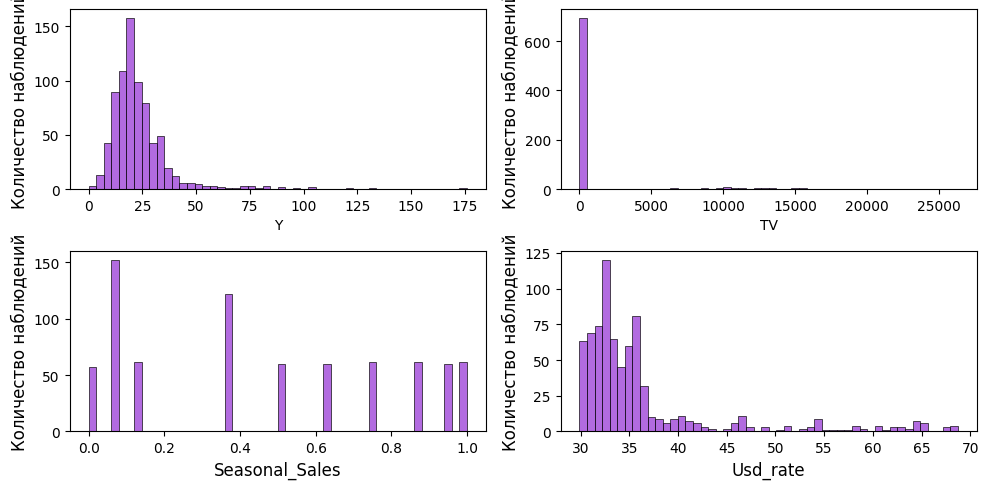

In [11]:
k = 0
m = 2
fig, axes = plt.subplots(m, m, figsize=(10, 5))

for i, ax in enumerate(axes.flat):
    if i >= len(features):
        break
    sns.histplot(ax=ax, data=df, x=features[i], color='#9939d6', bins = 50)
    ax.set_ylabel('Количество наблюдений', fontsize=12)
    if i >= m * (m - 1):  # Set x-label only for the bottom row
        ax.set_xlabel(features[i], fontsize=12)

plt.tight_layout()
plt.show()

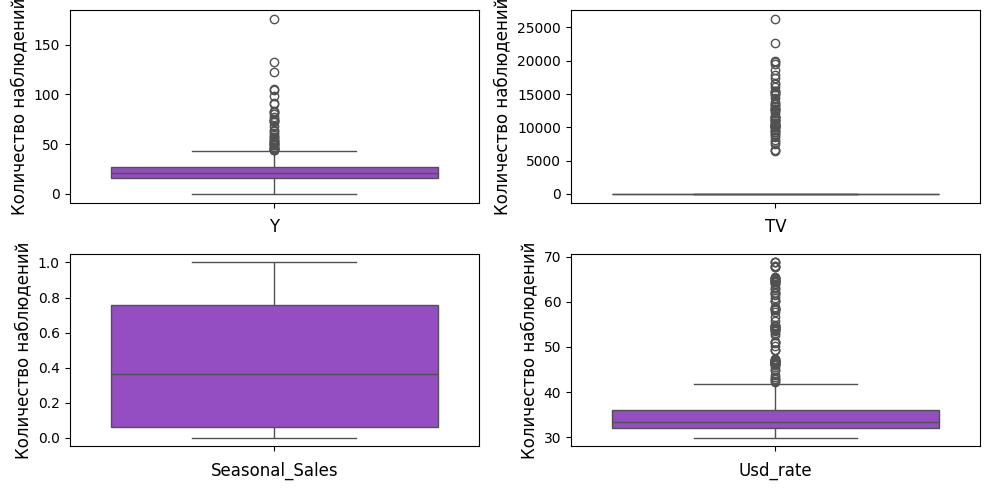

In [12]:
k = 0
m = 2
fig, axes = plt.subplots(m, m, figsize=(10, 5))

for i, ax in enumerate(axes.flat):
    if i >= len(features):
        break
    sns.boxplot(ax=ax, data=df, y=features[i], color='#9939d6')
    ax.set_ylabel('Количество наблюдений', fontsize=12)
    ax.set_xlabel(features[i], fontsize=12)

plt.tight_layout()
plt.show()

Выбросы не являются случайными, в TV это рекламная кампания, в USD - рост курса доллара

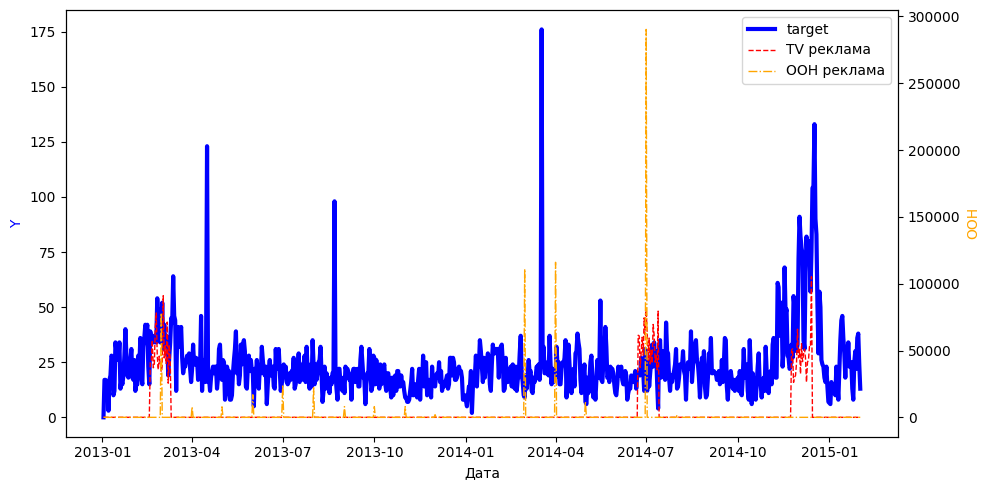

In [13]:
fig, ax1 = plt.subplots(figsize = (10,5))
ax1.plot(df['Date'], df['Y'], label='target', color='blue', linewidth=3)
ax1.set_xlabel('Дата')
ax1.set_ylabel('Y', color='blue')
ax2 = ax1.twinx()
ax2.plot(df['Date'], df['TV']*4, label='TV реклама', color='red', linewidth=1, linestyle='--')
ax2.set_ylabel('TV', color='red')
ax2.plot(df['Date'], df['OOH']*2, label='OOH реклама', color='orange', linewidth=1, linestyle='-.')
ax2.set_ylabel('OOH', color='orange')
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
fig.tight_layout()
plt.show()

график не отображает точных цифр, чтобы все вписалось в масштаб, но показывает, что воздействие рекламы происходит не сразу, а с определенным лагом

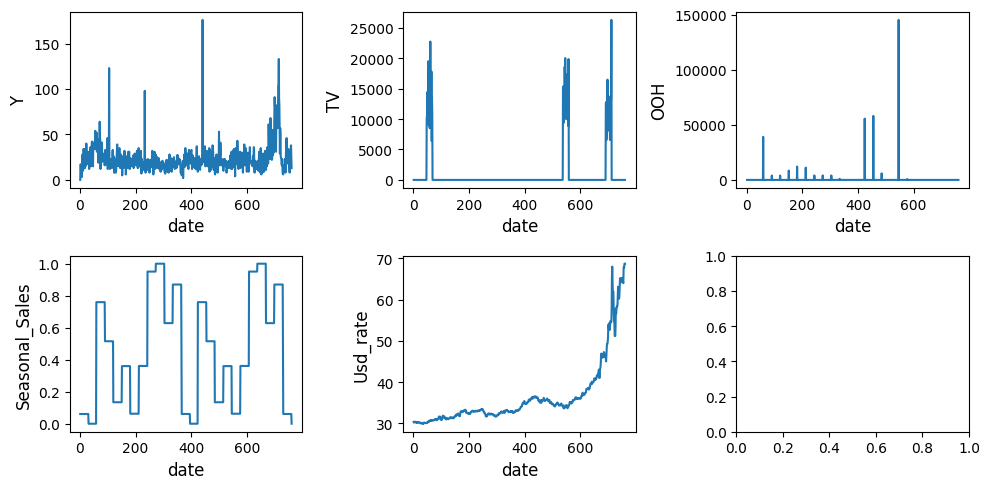

In [14]:
features = list(df.columns[1:])
k = 0
m = 2
n = 3
fig, axes = plt.subplots(m, n, figsize=(10, 5))

for i, ax in enumerate(axes.flat):
    if i >= len(features):
        break
    ax.plot(df[features[i]])
    ax.set_ylabel(features[i], fontsize=12)
    ax.set_xlabel('date', fontsize=12)

fig.tight_layout()
plt.show()

### Поиск лучшего лага
Попробуем выбрать лаг для фичей, связанных с рекламой. Важный момент - чем больше лаг, тем сильнее мы обрежем датасет.   
Также нужно определиться с одним единственным лагом для всех признаков , которые будут показывать наилучшую связь с таргетом

In [15]:
min_lag = 1
max_lag = 60
results = []
for lag in range(min_lag, max_lag + 1):
    target_trimmed = df['Y'].iloc[lag:]
    TV_trimmed = df['TV'].iloc[:-lag]
    OOH_trimmed = df['OOH'].iloc[:-lag]
    Season_trimmed = df['Seasonal_Sales'].iloc[:-lag]
    USD_trimmed = df['Usd_rate'].iloc[:-lag]
    # Считаем корреляцию
    TV_corr = target_trimmed.corr(TV_trimmed)
    OOH_corr = target_trimmed.corr(OOH_trimmed)
    Season_corr = target_trimmed.corr(Season_trimmed)
    USD_corr = target_trimmed.corr(USD_trimmed)
    results.append((lag, (TV_corr, OOH_corr, Season_corr, USD_corr)))
print("Результаты по лагам:")
for lag, corr in results:
    print(f"lag {lag}: tv = {corr[0]:.3f}, ooh = {corr[1]:.3f},seasons = {corr[2]:.3f}, usd = {corr[3]:.3f}")

Результаты по лагам:
lag 1: tv = 0.268, ooh = -0.019,seasons = 0.073, usd = 0.317
lag 2: tv = 0.268, ooh = -0.019,seasons = 0.073, usd = 0.320
lag 3: tv = 0.268, ooh = -0.019,seasons = 0.074, usd = 0.318
lag 4: tv = 0.268, ooh = -0.020,seasons = 0.074, usd = 0.317
lag 5: tv = 0.268, ooh = -0.020,seasons = 0.073, usd = 0.321
lag 6: tv = 0.268, ooh = -0.020,seasons = 0.071, usd = 0.321
lag 7: tv = 0.268, ooh = -0.020,seasons = 0.071, usd = 0.324
lag 8: tv = 0.268, ooh = -0.020,seasons = 0.069, usd = 0.332
lag 9: tv = 0.268, ooh = -0.020,seasons = 0.069, usd = 0.340
lag 10: tv = 0.268, ooh = -0.020,seasons = 0.069, usd = 0.343
lag 11: tv = 0.268, ooh = -0.020,seasons = 0.068, usd = 0.346
lag 12: tv = 0.268, ooh = -0.020,seasons = 0.067, usd = 0.350
lag 13: tv = 0.268, ooh = -0.020,seasons = 0.069, usd = 0.351
lag 14: tv = 0.269, ooh = -0.020,seasons = 0.070, usd = 0.356
lag 15: tv = 0.269, ooh = -0.020,seasons = 0.072, usd = 0.357
lag 16: tv = 0.269, ooh = -0.020,seasons = 0.072, usd = 0.

Корреляция с OOH минимальна, поэтому есть вариант вообще не использовать его в модели.    
Для TV корреляция начинает затухать с 51 лага, для USD_rate с 45. Сезонность тоже слабо влияет на результат, но до 39 лага оно увеличивается, пусть и незначительно

Оптимальным решением видится взятие лага 43

In [17]:
df['Y'].iloc[43:].corr(df['Usd_rate'].iloc[:-43])

np.float64(0.49792687987883116)

In [18]:
lag = 43
df['Y'] = df['Y'].iloc[lag:]
for i in features[1:]:
    df[i] = df[i].iloc[:-lag]
df.dropna(inplace=True)
df

,Date,Y,TV,OOH,Seasonal_Sales,Usd_rate
44,2013-02-14,39.0,0.0,0.0,0.000000,30.036600
45,2013-02-15,42.0,0.0,0.0,0.000000,30.045900
46,2013-02-16,23.0,0.0,0.0,0.000000,30.045900
47,2013-02-17,15.0,0.0,0.0,0.000000,30.045900
48,2013-02-18,39.0,10258.0,0.0,0.000000,30.096001
...,...,...,...,...,...,...
713,2014-12-15,104.0,0.0,0.0,0.869788,58.185001
714,2014-12-16,105.0,0.0,0.0,0.869788,65.509499
715,2014-12-17,133.0,0.0,0.0,0.869788,68.025002
716,2014-12-18,90.0,0.0,0.0,0.869788,65.019997


### Корреляционный анализ

In [19]:
def corr_test(data_1, data_2):
    correlation = pearsonr(data_1, data_2)
    return '{0:.3f}\n{1:.3f}'.format(*correlation)

In [22]:
df.columns[1:-2]

Index(['Y', 'TV', 'OOH'], dtype='object')

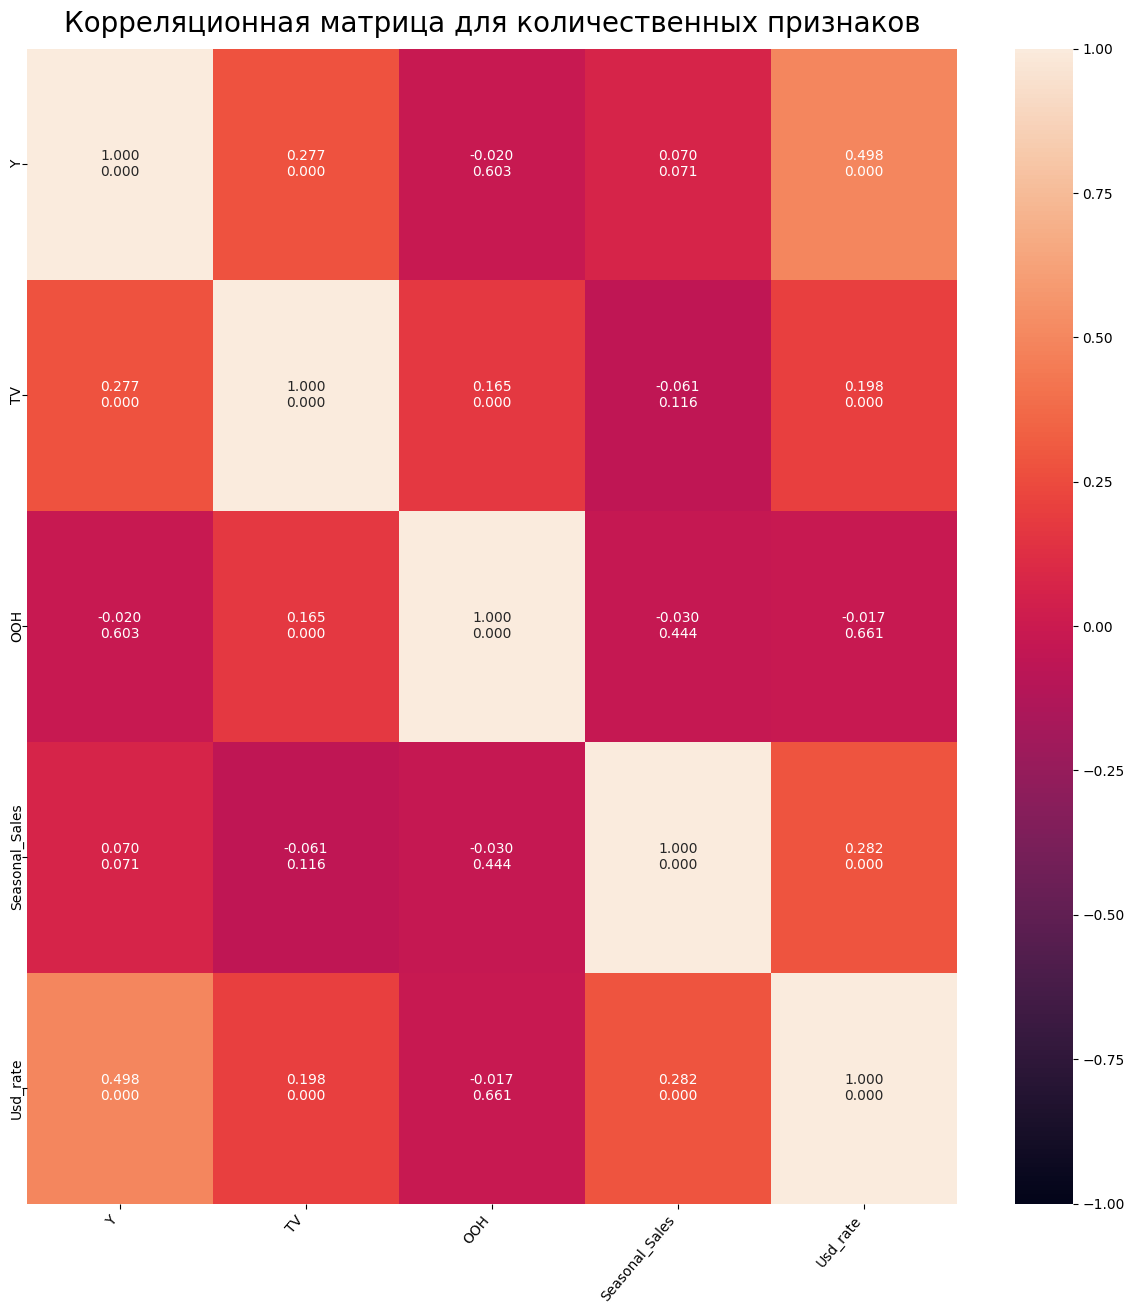

In [23]:
metric = df.columns[1:]
correlation = df[metric].corr()
text = [[corr_test(df[i], df[j]) for i in metric] for j in metric]
plt.figure(figsize=(15, 15))
heatmap = sns.heatmap(correlation, vmin=-1, vmax=1,  annot=text, fmt='')
heatmap.set_title('Корреляционная матрица для количественных признаков', fontdict={'fontsize':20}, pad=12)
heatmap.set_xticklabels(metric, rotation = 50, ha='right')
heatmap.set_yticklabels(metric,  ha ='center')
plt.show()


Хорошее значимое влияние на продажи оказывает TV реклама и курс доллара

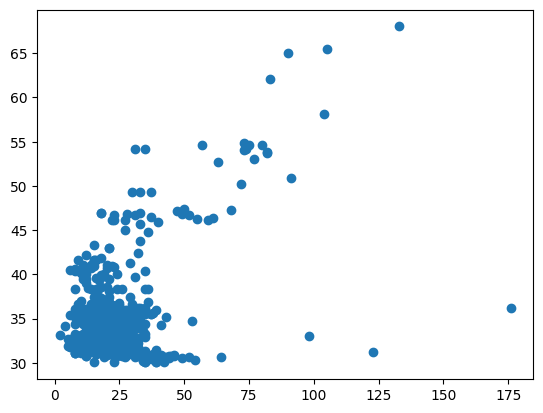

In [24]:
plt.scatter(df['Y'], df['Usd_rate'])

## Создание новых признаков
Создадим 2 категориальных признака: месяц и время года продажи автомобиля

In [25]:
df['Month'] = df['Date'].dt.month
df['Season'] = df['Month'].apply(get_season)

In [26]:
bins_ooh = [-1,0,8000, 15000, 500000]
lab_ooh = ['0','<8k', '8k-15k','>15k']
df['OOH_cat'] = pd.cut(df['OOH'],bins = bins_ooh, labels = lab_ooh)

In [27]:
cat = ['Month', 'Season', 'OOH_cat']

Стат. тесты

In [28]:
result = {}
for column in cat:
    groups = [df[df[column] == i]['Y'].values for i in df[column].unique() ]
    if any([kstest(i, 'norm').pvalue<0.05 for i in groups]):
        if len(groups) >2:
            result[column] = [kruskal(*groups), levene(*groups, center='median'), levene(*groups, center='mean')]
        else:
            result[column] = [mannwhitneyu(*groups), levene(*groups, center='median'), levene(*groups, center='mean')]
    else:
        result[column] = [ttest_ind(*groups), levene(*groups, center='median'), levene(*groups, center='mean')]
result

{'Month': [KruskalResult(statistic=np.float64(57.420021513757845), pvalue=np.float64(2.7841451745307972e-08)),
  LeveneResult(statistic=np.float64(11.258350441210274), pvalue=np.float64(2.5594695105861963e-19)),
  LeveneResult(statistic=np.float64(25.458829104051883), pvalue=np.float64(3.7752510362002957e-44))],
 'Season': [KruskalResult(statistic=np.float64(31.381180476468113), pvalue=np.float64(7.065928933837331e-07)),
  LeveneResult(statistic=np.float64(14.647146237766226), pvalue=np.float64(3.0068358946961538e-09)),
  LeveneResult(statistic=np.float64(23.64019985601343), pvalue=np.float64(1.4946147858541063e-14))],
 'OOH_cat': [KruskalResult(statistic=np.float64(5.532861477504949), pvalue=np.float64(0.13668629525949902)),
  LeveneResult(statistic=np.float64(0.49058964701388413), pvalue=np.float64(0.6889214668955949)),
  LeveneResult(statistic=np.float64(0.6033774796520465), pvalue=np.float64(0.6129701703543827))]}

Влияние месяца и сезона на продажи есть, влияние наружной рекламы не обнаружено, поэтому пока не добавляем в модель

Готовимся к построению моделей

In [29]:
numeric = ['Y', 'TV', 'Usd_rate']
cat = ['Month']
features = numeric+cat

In [30]:
df_encoded = pd.get_dummies(df[features], columns=cat)
df_encoded.head()

,Y,TV,Usd_rate,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
44,39.0,0.0,30.036600,False,True,False,False,False,False,False,False,False,False,False,False
45,42.0,0.0,30.045900,False,True,False,False,False,False,False,False,False,False,False,False
46,23.0,0.0,30.045900,False,True,False,False,False,False,False,False,False,False,False,False
47,15.0,0.0,30.045900,False,True,False,False,False,False,False,False,False,False,False,False
48,39.0,10258.0,30.096001,False,True,False,False,False,False,False,False,False,False,False,False


In [31]:
X_train, X_test, y_train, y_test = train_test_split(
    df_encoded.drop('Y', axis = 1),
    df_encoded['Y'],
    test_size=0.3,
    random_state=42)

### Скалирование

In [32]:
scaler_x = StandardScaler()
X_train_scaled = scaler_x.fit_transform(X_train[numeric[1:]])
X_test_scaled = scaler_x.transform(X_test[numeric[1:]])
for n in range(len(numeric[1:])):
    X_train[numeric[1:][n]] = X_train_scaled[:,n]
scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()